### Step 1: setup and data modeling

In [1]:
import os
import pandas as pd
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/mlflow/utils/requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


In [2]:
mlflow.set_tracking_uri("http://localhost:5001")

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
artifact_path = os.path.join(project_root, "mlflow", "artifacts")
artifact_uri = f"file://{artifact_path}"
print(f"Artifact URI: {artifact_uri}")

experiment_name = "crop_yield_prediction"

try:
    experiment_id = mlflow.create_experiment(
        experiment_name,
        artifact_location=artifact_uri
    )
    print(f"Created new experiment with ID: {experiment_id}")
except:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
    print(f"Using existing experiment with ID: {experiment_id}")

mlflow.set_experiment(experiment_name)
print(f"Artifact location: {artifact_uri}")

Artifact URI: file:///Users/adetsi/Desktop/projects/agrosense/mlflow/artifacts
Using existing experiment with ID: 1
Artifact location: file:///Users/adetsi/Desktop/projects/agrosense/mlflow/artifacts


#### Loading snowflake data

In [3]:
from snowflake.connector import connect
import os
from dotenv import load_dotenv
load_dotenv()

conn = connect(
    account=os.getenv('SNOWFLAKE_ACCOUNT'),
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    database=os.getenv('SNOWFLAKE_DB'),
    warehouse=os.getenv('SNOWFLAKE_WH'),
    role=os.getenv('SNOWFLAKE_ROLE'),
    schema=os.getenv('SNOWFLAKE_SCHEMA')
)

query = "SELECT * FROM  AGROSENSE_DB.AGROSENSE_SCH.FCT_ML_TRAINING_DATASET"
df = pd.read_sql(query, conn)
conn.close()

df.head()

/var/folders/x4/rrw9x5l50yz_6clmyp_y58sm0000gn/T/ipykernel_31117/1733229511.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,TARGET_YIELD,AREA,CROP_TYPE,YEAR,AVERAGE_RAINFALL_MM_PER_YEAR,PESTICIDES_TONNES,AVG_TEMP,YIELD_EFFICIENCY,PESTICIDE_INTENSITY,YEAR_IN_DECADE,ERA
0,36613,Albania,Maize,1990,1485.0,121.0,16.37,24.655219,0.081481,0,historical
1,66667,Albania,Potatoes,1990,1485.0,121.0,16.37,44.893603,0.081481,0,historical
2,23333,Albania,"Rice, paddy",1990,1485.0,121.0,16.37,15.712458,0.081481,0,historical
3,12500,Albania,Sorghum,1990,1485.0,121.0,16.37,8.417508,0.081481,0,historical
4,7000,Albania,Soybeans,1990,1485.0,121.0,16.37,4.713805,0.081481,0,historical


#### Exploring the behavior of the data

In [4]:
df.sample(5)

,TARGET_YIELD,AREA,CROP_TYPE,YEAR,AVERAGE_RAINFALL_MM_PER_YEAR,PESTICIDES_TONNES,AVG_TEMP,YIELD_EFFICIENCY,PESTICIDE_INTENSITY,YEAR_IN_DECADE,ERA
23611,51948,Portugal,"Rice, paddy",1992,854.0,6117.00,15.95,60.829040,7.162763,2,historical
10178,140017,Honduras,Plantains and others,1992,1976.0,9904.59,24.77,70.858806,5.012444,2,historical
9640,28922,Guatemala,"Rice, paddy",2009,1996.0,13276.70,19.99,14.489980,6.651653,9,historical
5732,112323,Canada,Potatoes,1996,537.0,35240.80,5.81,209.167598,65.625326,6,historical
12179,8472,India,Sorghum,1999,1083.0,46195.00,25.74,7.822715,42.654663,9,historical


In [5]:
df.shape

(28242, 11)

In [6]:
df.isna().any().sum()

0

In [7]:
print(df.describe())

        TARGET_YIELD          YEAR  AVERAGE_RAINFALL_MM_PER_YEAR  \
count   28242.000000  28242.000000                   28242.00000   
mean    77053.332094   2001.544296                    1149.05598   
std     84956.612897      7.051905                     709.81215   
min        50.000000   1990.000000                      51.00000   
25%     19919.250000   1995.000000                     593.00000   
50%     38295.000000   2001.000000                    1083.00000   
75%    104676.750000   2008.000000                    1668.00000   
max    501412.000000   2013.000000                    3240.00000   

       PESTICIDES_TONNES      AVG_TEMP  YIELD_EFFICIENCY  PESTICIDE_INTENSITY  \
count       28242.000000  28242.000000      28242.000000         28242.000000   
mean        37076.909344     20.542627        136.310738            36.344838   
std         59958.784665      6.312051        392.177079            42.976550   
min             0.040000      1.300000          0.072359       

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TARGET_YIELD                  28242 non-null  int64  
 1   AREA                          28242 non-null  object 
 2   CROP_TYPE                     28242 non-null  object 
 3   YEAR                          28242 non-null  int64  
 4   AVERAGE_RAINFALL_MM_PER_YEAR  28242 non-null  float64
 5   PESTICIDES_TONNES             28242 non-null  float64
 6   AVG_TEMP                      28242 non-null  float64
 7   YIELD_EFFICIENCY              28242 non-null  float64
 8   PESTICIDE_INTENSITY           28242 non-null  float64
 9   YEAR_IN_DECADE                28242 non-null  int64  
 10  ERA                           28242 non-null  object 
dtypes: float64(5), int64(3), object(3)
memory usage: 2.4+ MB


In [9]:
print("Unique AREA Values:\n", df['AREA'].unique())
print("Number of Unique AREA Values:", df['AREA'].nunique(), "\n")

print("Unique CROP_TYPE Values:\n", df['CROP_TYPE'].unique())
print("Number of Unique CROP_TYPE Values:", df['CROP_TYPE'].nunique(), "\n")

print("Unique ERA Values:\n", df['ERA'].unique())
print("Number of Unique ERA Values:", df['ERA'].nunique(), "\n")

Unique AREA Values:
 ['Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Belarus' 'Belgium'
 'Botswana' 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cameroon'
 'Canada' 'Central African Republic' 'Chile' 'Colombia' 'Croatia'
 'Denmark' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Eritrea'
 'Estonia' 'Finland' 'France' 'Germany' 'Ghana' 'Greece' 'Guatemala'
 'Guinea' 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'India' 'Indonesia' 'Iraq'
 'Ireland' 'Italy' 'Jamaica' 'Japan' 'Kazakhstan' 'Kenya' 'Latvia'
 'Lebanon' 'Lesotho' 'Libya' 'Lithuania' 'Madagascar' 'Malawi' 'Malaysia'
 'Mali' 'Mauritania' 'Mauritius' 'Mexico' 'Montenegro' 'Morocco'
 'Mozambique' 'Namibia' 'Nepal' 'Netherlands' 'New Zealand' 'Nicaragua'
 'Niger' 'Norway' 'Pakistan' 'Papua New Guinea' 'Peru' 'Poland' 'Portugal'
 'Qatar' 'Romania' 'Rwanda' 'Saudi Arabia' 'Senegal' 'Slovenia'
 'South Africa' 'Spain' 'Sri Lanka' 'Sudan' 'Suriname' 'Sweden'
 'Swi

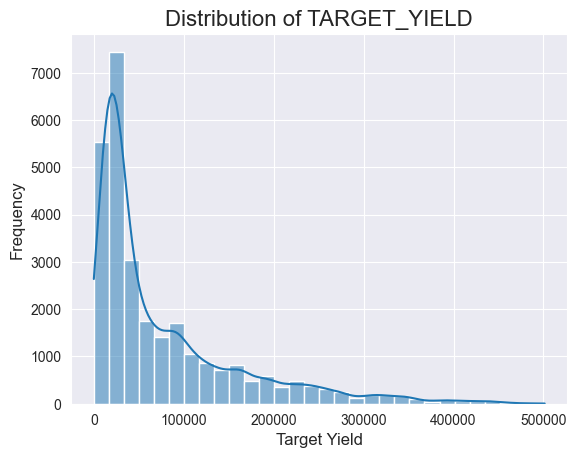

In [10]:
sns.histplot(df['TARGET_YIELD'], kde=True, bins=30)

plt.title("Distribution of TARGET_YIELD", fontsize=16)
plt.xlabel("Target Yield", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

### Step 2: Feature Engineering and Preprocessing

In [11]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

df_model = df.copy()

X = df_model.drop(['TARGET_YIELD'], axis=1)
y = df_model['TARGET_YIELD']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

label_encoders = {}
categorical_cols = ['AREA','CROP_TYPE','ERA']

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"\n'{col} encoded': {le.classes_} unique values")

Features shape: (28242, 10)
Target shape: (28242,)

'AREA encoded': ['Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Belarus' 'Belgium'
 'Botswana' 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cameroon'
 'Canada' 'Central African Republic' 'Chile' 'Colombia' 'Croatia'
 'Denmark' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Eritrea'
 'Estonia' 'Finland' 'France' 'Germany' 'Ghana' 'Greece' 'Guatemala'
 'Guinea' 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'India' 'Indonesia' 'Iraq'
 'Ireland' 'Italy' 'Jamaica' 'Japan' 'Kazakhstan' 'Kenya' 'Latvia'
 'Lebanon' 'Lesotho' 'Libya' 'Lithuania' 'Madagascar' 'Malawi' 'Malaysia'
 'Mali' 'Mauritania' 'Mauritius' 'Mexico' 'Montenegro' 'Morocco'
 'Mozambique' 'Namibia' 'Nepal' 'Netherlands' 'New Zealand' 'Nicaragua'
 'Niger' 'Norway' 'Pakistan' 'Papua New Guinea' 'Peru' 'Poland' 'Portugal'
 'Qatar' 'Romania' 'Rwanda' 'Saudi Arabia' 'Senegal' 'Slovenia'
 'South Africa' 'Spain

### Step 3: Train-Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

Training data shape: (22593, 10)
Testing data shape: (5649, 10)


In [13]:
X_train_scaled

array([[-1.06269025,  0.21913139,  0.48627038, ..., -0.83647846,
         0.31962803, -0.46586797],
       [-0.16837445,  0.59818624, -1.3559997 , ...,  0.67303524,
        -0.70057767, -0.46586797],
       [-1.43532184, -1.67614287, -0.64743428, ..., -0.83978692,
         0.99976515, -0.46586797],
       ...,
       [-1.54711131, -0.53897832, -1.49771279, ..., -0.06972196,
        -1.04064623, -0.46586797],
       [-0.01932182,  0.97724109, -0.78914737, ...,  1.2391102 ,
         0.65969659, -0.46586797],
       [ 1.13583609,  0.97724109, -0.36400812, ..., -0.42845852,
         1.67990228, -0.46586797]])

### Step 4: Train Model with MLflow Tracking

In [14]:
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

with mlflow.start_run(run_name='random_forest_baseline'):
    params = {
        'n_estimators': 100,
        'max_depth': 20,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42,
        'n_jobs': -1
    }
    mlflow.log_params(params)

    print("Training Random Forest model...")
    rf_model = RandomForestRegressor(**params)
    rf_model.fit(X_train_scaled, y_train)

    y_pred_train = rf_model.predict(X_train_scaled)
    y_pred_test = rf_model.predict(X_test_scaled)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    mlflow.log_metric('train_mse', train_rmse)
    mlflow.log_metric('test_mse', test_rmse)
    mlflow.log_metric('train_mae', train_mae)
    mlflow.log_metric('test_mae', test_mae)
    mlflow.log_metric('train_r2', train_r2)

    mlflow.sklearn.log_model(rf_model, artifact_path="random_forest_model", registered_model_name="RandomForestRegressorModel")

    print("\n" + "="*50)
    print("MODEL PERFORMANCE")
    print("="*50)
    print(f"Train RMSE: {train_rmse:,.2f}")
    print(f"Test RMSE:  {test_rmse:,.2f}")
    print(f"Train MAE:  {train_mae:,.2f}")
    print(f"Test MAE:   {test_mae:,.2f}")
    print(f"Train R²:   {train_r2:.4f}")
    print(f"Test R²:    {test_r2:.4f}")
    print("="*50)

    run_id = mlflow.active_run().info.run_id
    print(f"Run ID: {run_id}")

Training Random Forest model...


Registered model 'RandomForestRegressorModel' already exists. Creating a new version of this model...
2025/10/27 16:12:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestRegressorModel, version 6



MODEL PERFORMANCE
Train RMSE: 1,317.71
Test RMSE:  2,990.47
Train MAE:  284.11
Test MAE:   631.71
Train R²:   0.9998
Test R²:    0.9988
Run ID: 4479c25c5852426b933d8f41abfa160c


Created version '6' of model 'RandomForestRegressorModel'.


#### Results
- We're getting exceptional results of 99.9% r2 - which means the model explain 99.9% of the variability in the dataset,
- However, this is too good to be true for a baseline model, hence we need to investigate the validity of this results
- Who knows there may be a data leakage somewhere

### Step 5: Model Analysis & Visualization

In [15]:
# Create predictions DataFrame for analysis
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test,
    'Error': y_test - y_pred_test,
    'Absolute_Error': np.abs(y_test - y_pred_test),
    'Percentage_Error': np.abs((y_test - y_pred_test) / y_test) * 100
})

crop_type_class_to_index = {label: idx for idx, label in enumerate(label_encoders['CROP_TYPE'].classes_)}
area_class_to_index = {label: idx for idx, label in enumerate(label_encoders['AREA'].classes_)}

crop_type_index_to_class = {v: k for k, v in crop_type_class_to_index.items()}
area_index_to_class = {v: k for k, v in area_class_to_index.items()}

results_df['CROP_TYPE'] = X_test['CROP_TYPE'].map(crop_type_index_to_class).values
results_df['AREA'] = X_test['AREA'].map(area_index_to_class).values


print("Prediction Analysis:")
print(f"Mean Absolute Percentage Error: {results_df['Percentage_Error'].mean():.2f}%")
print(f"Median Absolute Percentage Error: {results_df['Percentage_Error'].median():.2f}%")
print("\nWorst Predictions:")
print(results_df.nlargest(5, 'Absolute_Error')[['Actual', 'Predicted', 'Error', 'CROP_TYPE', 'AREA']])

Prediction Analysis:
Mean Absolute Percentage Error: 0.76%
Median Absolute Percentage Error: 0.14%

Worst Predictions:
       Actual      Predicted         Error CROP_TYPE         AREA
2075   255556  190773.265500  64782.734500  Potatoes      Bahrain
199    292806  231429.123262  61376.876738  Potatoes      Algeria
20781  363561  306491.545274  57069.454726  Potatoes      Morocco
26159  457778  402132.679078  55645.320922  Potatoes  Switzerland
8874   468991  413768.164103  55222.835897  Potatoes       France


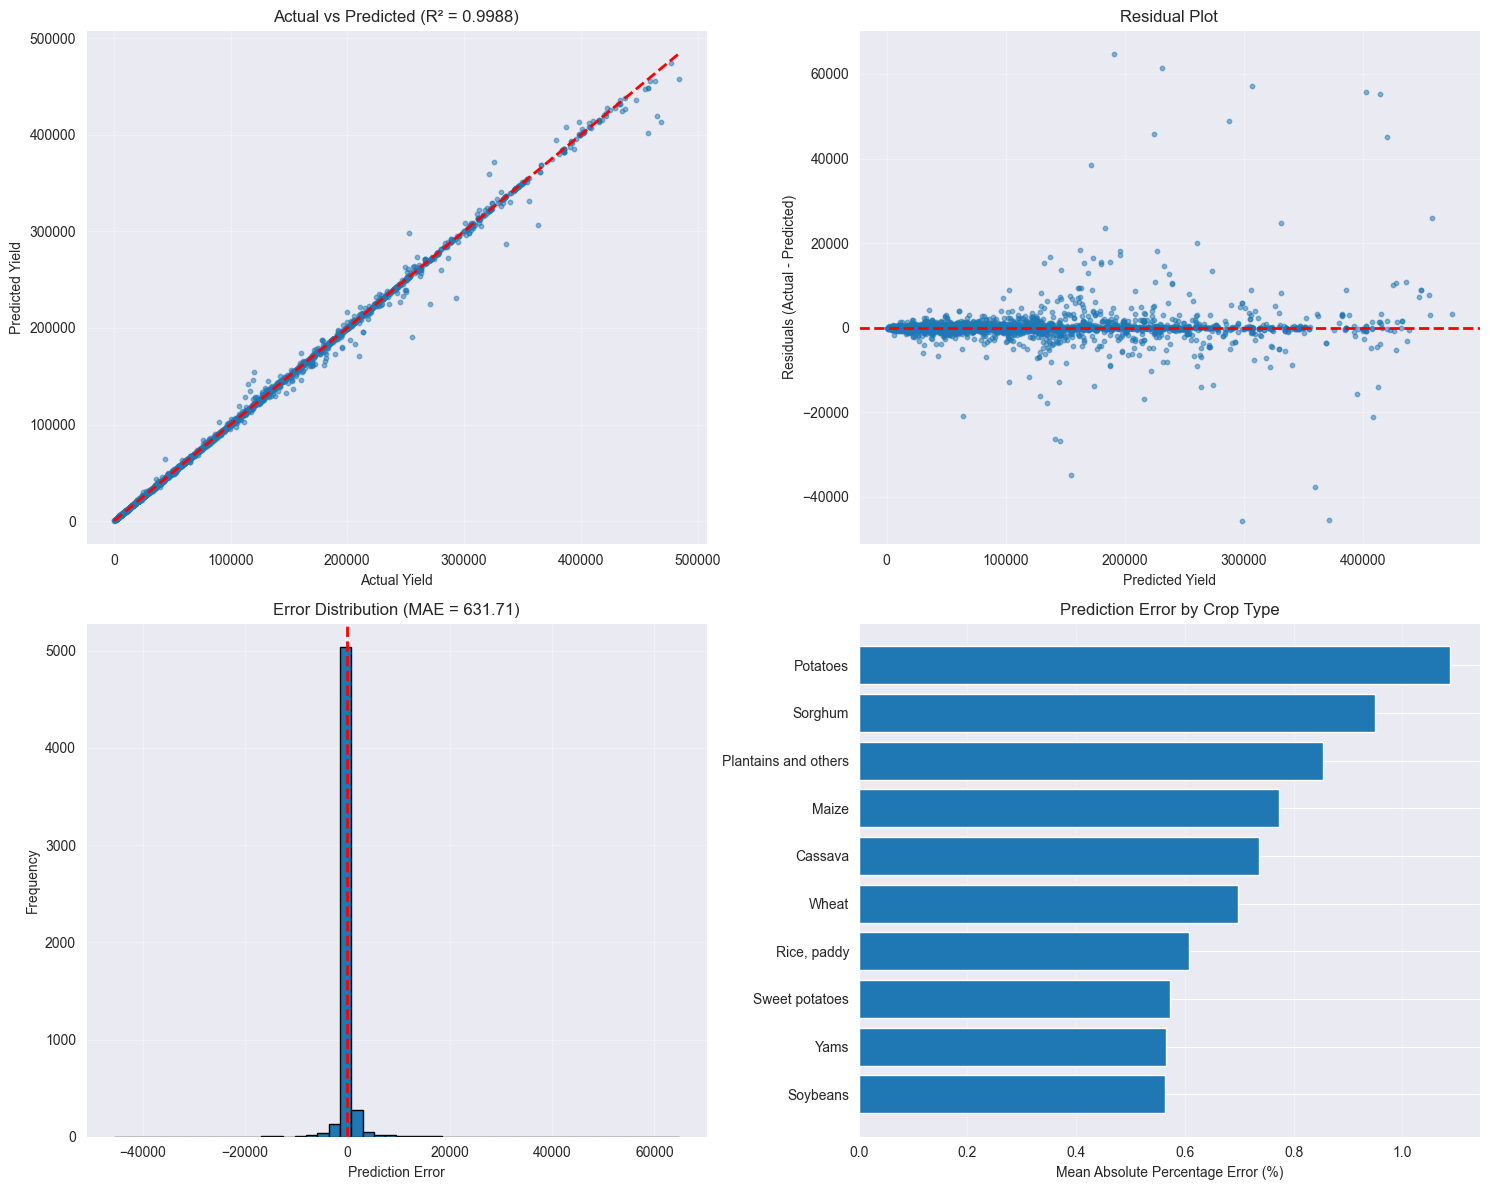

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.5, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Yield')
axes[0, 0].set_ylabel('Predicted Yield')
axes[0, 0].set_title(f'Actual vs Predicted (R² = {test_r2:.4f})')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals plot
axes[0, 1].scatter(y_pred_test, results_df['Error'], alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Yield')
axes[0, 1].set_ylabel('Residuals (Actual - Predicted)')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Error distribution
axes[1, 0].hist(results_df['Error'], bins=50, edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Prediction Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Error Distribution (MAE = {test_mae:.2f})')
axes[1, 0].grid(True, alpha=0.3)

# 4. Percentage error by crop type
crop_errors = results_df.groupby('CROP_TYPE')['Percentage_Error'].mean().sort_values()
axes[1, 1].barh(crop_errors.index, crop_errors.values)
axes[1, 1].set_xlabel('Mean Absolute Percentage Error (%)')
axes[1, 1].set_title('Prediction Error by Crop Type')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


Feature Importance:
                        Feature  Importance
6              YIELD_EFFICIENCY    0.736341
3  AVERAGE_RAINFALL_MM_PER_YEAR    0.257609
5                      AVG_TEMP    0.001525
4             PESTICIDES_TONNES    0.001261
7           PESTICIDE_INTENSITY    0.001076
0                          AREA    0.000799
2                          YEAR    0.000719
1                     CROP_TYPE    0.000458
8                YEAR_IN_DECADE    0.000175
9                           ERA    0.000037


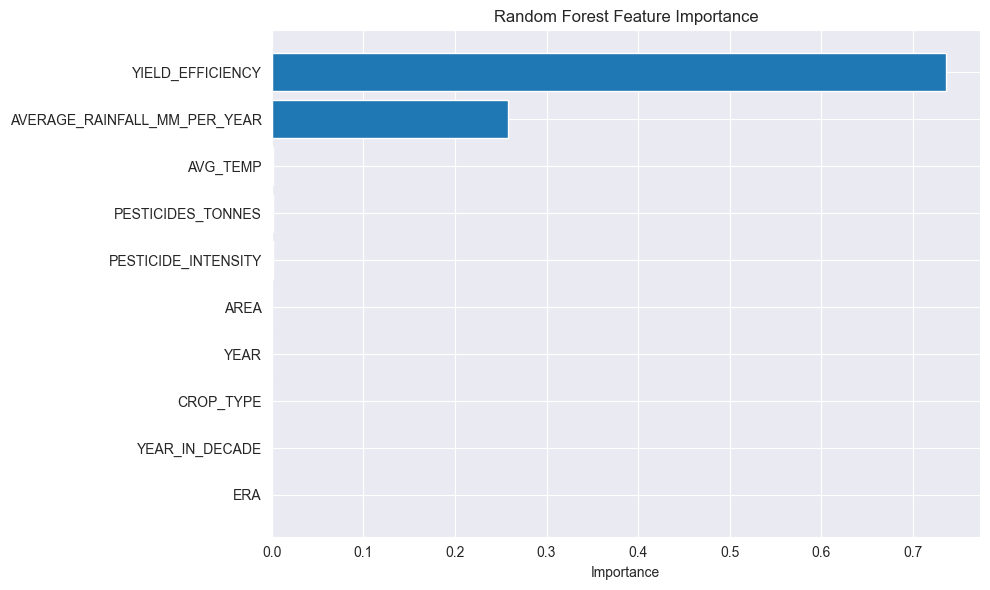

In [17]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Step 6: Investigating Data Leakage

Correlation Matrix:
TARGET_YIELD                    1.000000
YIELD_EFFICIENCY                0.378550
PESTICIDE_INTENSITY             0.102640
AVERAGE_RAINFALL_MM_PER_YEAR    0.000962
AVG_TEMP                       -0.114777
Name: TARGET_YIELD, dtype: float64


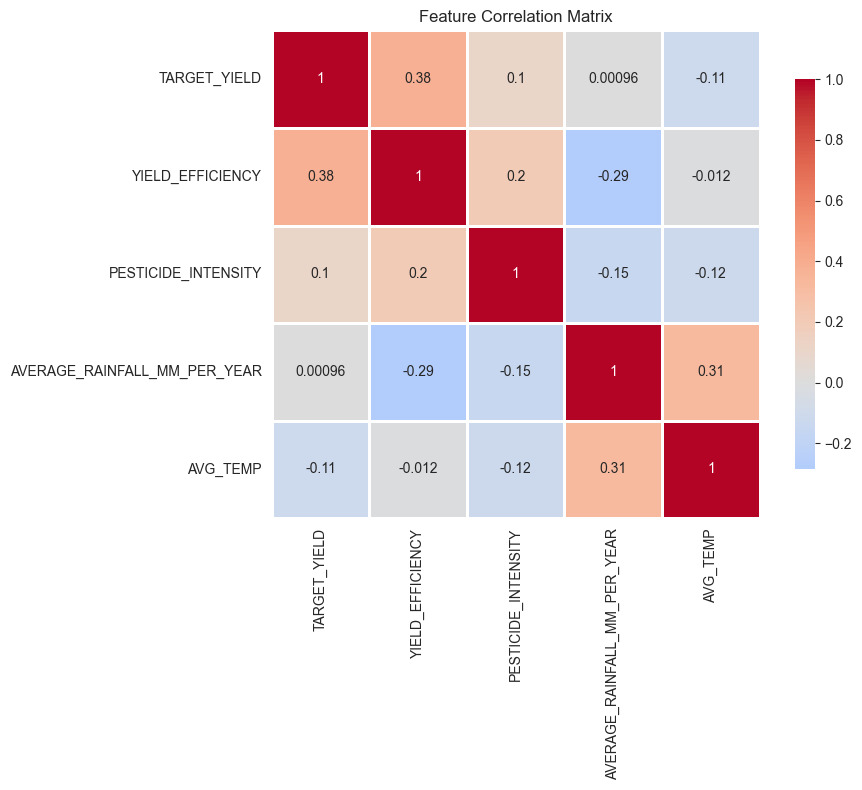


Sample data:
   TARGET_YIELD  YIELD_EFFICIENCY     AREA  PESTICIDES_TONNES
0         36613         24.655219  Albania              121.0
1         66667         44.893603  Albania              121.0
2         23333         15.712458  Albania              121.0
3         12500          8.417508  Albania              121.0
4          7000          4.713805  Albania              121.0
5         30197         20.334680  Albania              121.0
6         29068         19.574411  Albania              121.0
7         77818         52.402694  Albania              121.0
8         28538         19.217508  Albania              121.0
9          6667          4.489562  Albania              121.0


In [18]:
print("Correlation Matrix:")
correlation = df[['TARGET_YIELD', 'YIELD_EFFICIENCY', 'PESTICIDE_INTENSITY',
                   'AVERAGE_RAINFALL_MM_PER_YEAR', 'AVG_TEMP']].corr()
print(correlation['TARGET_YIELD'].sort_values(ascending=False))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("\nSample data:")
print(df[['TARGET_YIELD', 'YIELD_EFFICIENCY', 'AREA', 'PESTICIDES_TONNES']].head(10))

### Step 7: Train a fair model (without suspected leaked feature)

In [19]:
features_to_remove = ['YIELD_EFFICIENCY', 'PESTICIDE_INTENSITY']

X_clean = df.drop(['TARGET_YIELD'] + features_to_remove, axis=1)
y_clean = df['TARGET_YIELD']

X_clean_encoded = X_clean.copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_clean_encoded[col] = le.fit_transform(X_clean[col])

print(f"Features after removing leakage: {X_clean_encoded.columns.tolist()}")

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean_encoded, y_clean,
    test_size=0.2,
    random_state=42
)

print(f"Training set: {X_train_clean.shape}")
print(f"Test set: {X_test_clean.shape}")

Features after removing leakage: ['AREA', 'CROP_TYPE', 'YEAR', 'AVERAGE_RAINFALL_MM_PER_YEAR', 'PESTICIDES_TONNES', 'AVG_TEMP', 'YEAR_IN_DECADE', 'ERA']
Training set: (22593, 8)
Test set: (5649, 8)


In [20]:
with mlflow.start_run(run_name="random_forest_no_leakage"):

    params = {
        'n_estimators': 100,
        'max_depth': 20,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42,
        'n_jobs': -1
    }
    mlflow.log_params(params)
    mlflow.log_param("features_removed", "YIELD_EFFICIENCY, PESTICIDE_INTENSITY")

    print("Training Random Forest model (no leakage)...")
    rf_model_clean = RandomForestRegressor(**params)
    rf_model_clean.fit(X_train_clean, y_train_clean)

    y_pred_train_clean = rf_model_clean.predict(X_train_clean)
    y_pred_test_clean = rf_model_clean.predict(X_test_clean)

    train_rmse = np.sqrt(mean_squared_error(y_train_clean, y_pred_train_clean))
    test_rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_test_clean))
    train_mae = mean_absolute_error(y_train_clean, y_pred_train_clean)
    test_mae = mean_absolute_error(y_test_clean, y_pred_test_clean)
    train_r2 = r2_score(y_train_clean, y_pred_train_clean)
    test_r2 = r2_score(y_test_clean, y_pred_test_clean)

    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("test_r2", test_r2)

    mlflow.sklearn.log_model(
        rf_model_clean,
        artifact_path="random_forest_model",
        registered_model_name="CropYieldPredictor_NoLeakage"
    )

    print("\n" + "="*50)
    print("MODEL PERFORMANCE (NO LEAKAGE)")
    print("="*50)
    print(f"Train RMSE: {train_rmse:,.2f}")
    print(f"Test RMSE:  {test_rmse:,.2f}")
    print(f"Train MAE:  {train_mae:,.2f}")
    print(f"Test MAE:   {test_mae:,.2f}")
    print(f"Train R²:   {train_r2:.4f}")
    print(f"Test R²:    {test_r2:.4f}")
    print("="*50)

    run_id = mlflow.active_run().info.run_id
    print(f"\nMLflow Run ID: {run_id}")

Training Random Forest model (no leakage)...


/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Registered model 'CropYieldPredictor_NoLeakage' already exists. Creating a new version of thi


MODEL PERFORMANCE (NO LEAKAGE)
Train RMSE: 5,878.97
Test RMSE:  10,740.36
Train MAE:  2,181.98
Test MAE:   4,124.76
Train R²:   0.9952
Test R²:    0.9841

MLflow Run ID: 283d09da545047af9ea99315de11b76d


Created version '6' of model 'CropYieldPredictor_NoLeakage'.


## Comparison: Before vs After Removing Leakage

| Metric | With Leakage | Without Leakage | Change |
|--------|--------------|-----------------|--------|
| **Test R²** | 0.9988 | 0.9841 | -1.47% |
| **Test RMSE** | 2,990 | 10,740 | +259% |
| **Test MAE** | 632 | 4,125 | +553% |

- Good news, there are no leakage - removing the suspected features (['YIELD_EFFICIENCY', 'PESTICIDE_INTENSITY']) and retraining still gave exceptional results
- There isn't a very high collinearity between the target feature ('TARGET_YIELD') and 'YIELD_EFFICIENCY' like we suspected - just `0.38` which is reasonable
- `YIELD_EFFICIENCY (0.38 correlation)` was helpful but not as super important as feature importance suggested

### Step 8: Analyze supposed fair model


Feature Importance (No Leakage):
                        Feature  Importance
1                     CROP_TYPE    0.611354
4             PESTICIDES_TONNES    0.109094
5                      AVG_TEMP    0.107581
3  AVERAGE_RAINFALL_MM_PER_YEAR    0.086493
0                          AREA    0.054472
2                          YEAR    0.028036
6                YEAR_IN_DECADE    0.002445
7                           ERA    0.000523


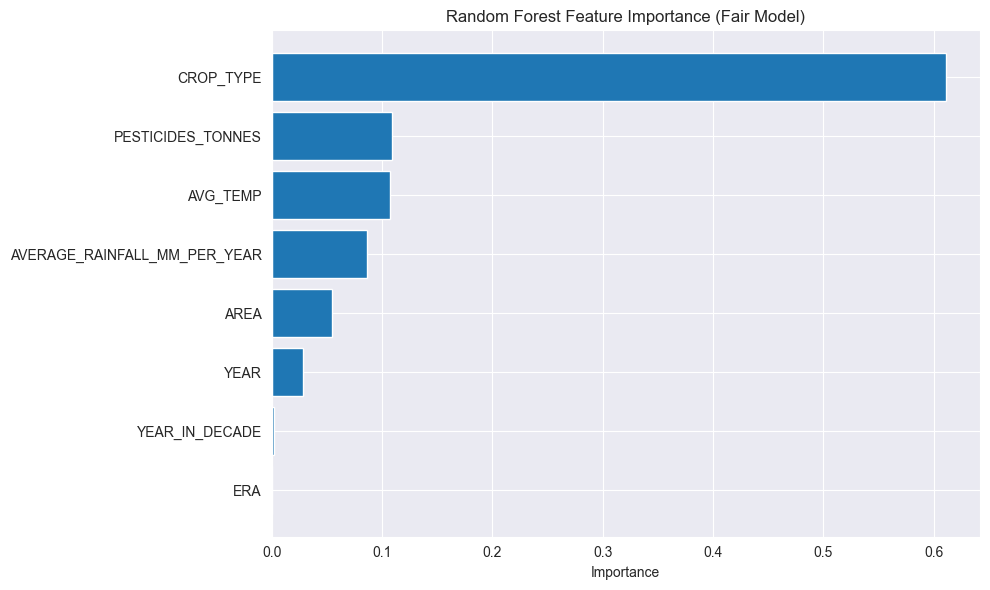

In [21]:
feature_importance_clean = pd.DataFrame({
    'Feature': X_clean_encoded.columns,
    'Importance': rf_model_clean.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (No Leakage):")
print(feature_importance_clean)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_clean['Feature'], feature_importance_clean['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance (Fair Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Prediction Analysis (Fair Model):
Mean Absolute Percentage Error: 8.58%
Median Absolute Percentage Error: 2.23%


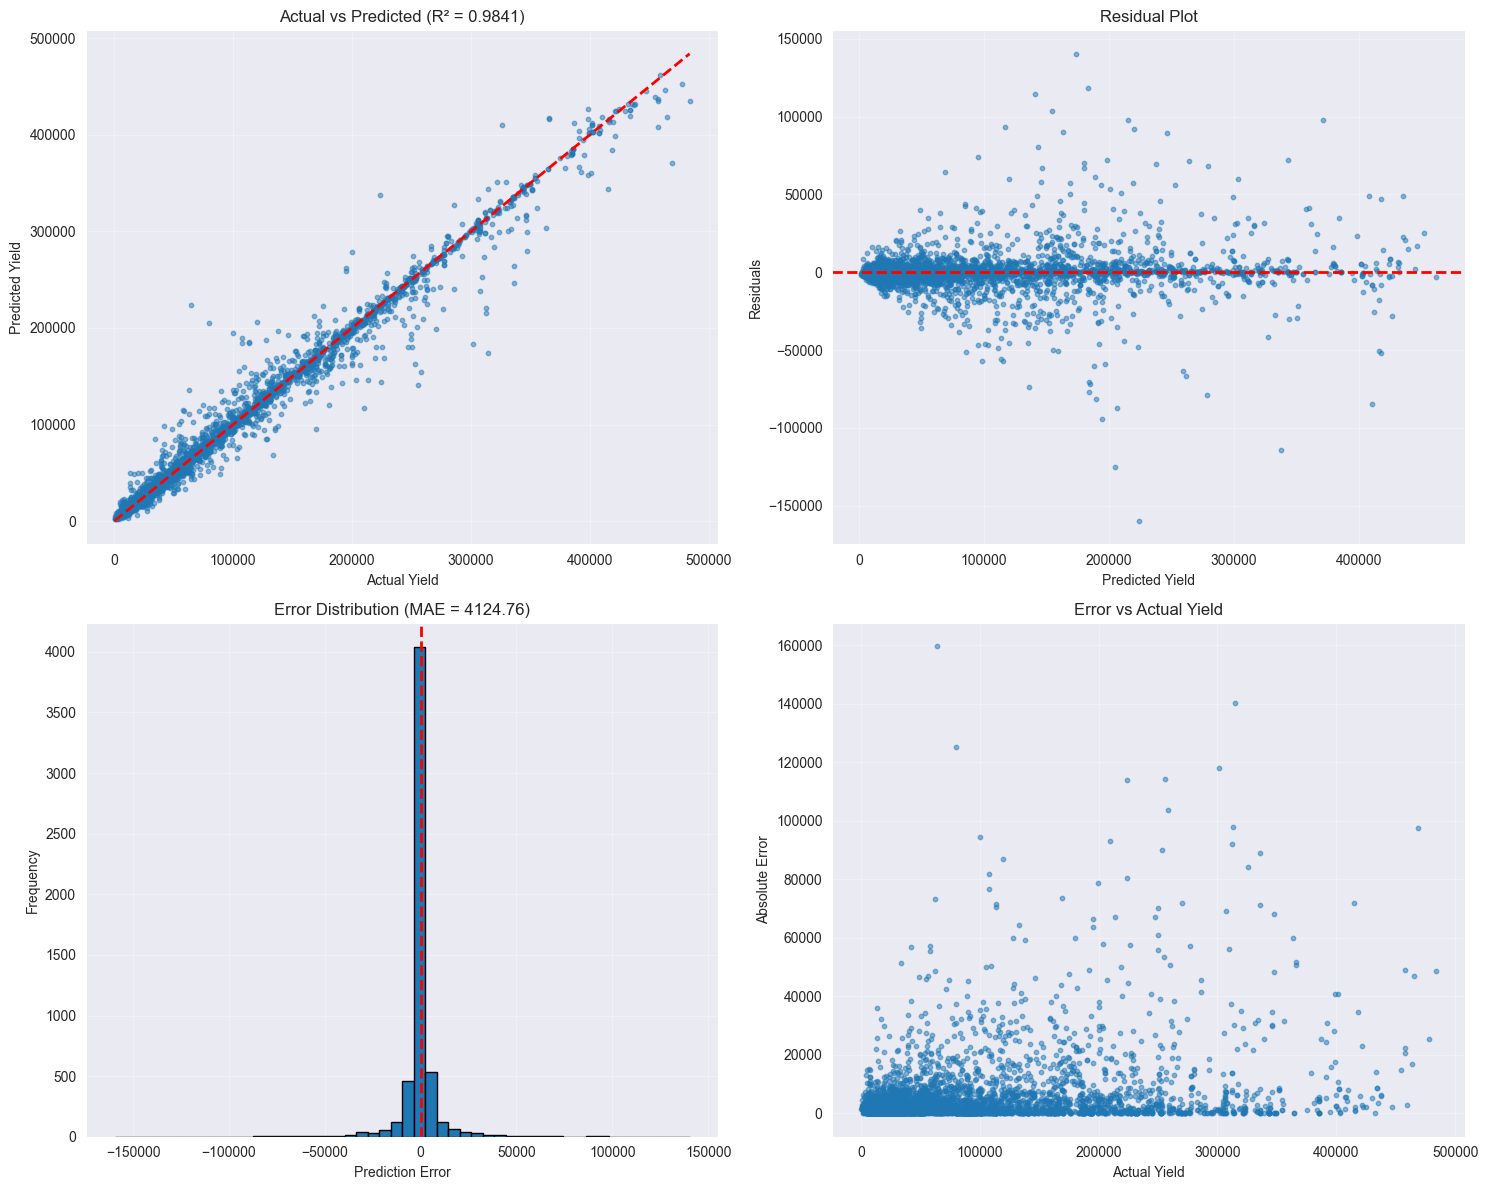

In [22]:
results_clean = pd.DataFrame({
    'Actual': y_test_clean,
    'Predicted': y_pred_test_clean,
    'Error': y_test_clean - y_pred_test_clean,
    'Absolute_Error': np.abs(y_test_clean - y_pred_test_clean),
    'Percentage_Error': np.abs((y_test_clean - y_pred_test_clean) / y_test_clean) * 100
})

print("\nPrediction Analysis (Fair Model):")
print(f"Mean Absolute Percentage Error: {results_clean['Percentage_Error'].mean():.2f}%")
print(f"Median Absolute Percentage Error: {results_clean['Percentage_Error'].median():.2f}%")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].scatter(y_test_clean, y_pred_test_clean, alpha=0.5, s=10)
axes[0, 0].plot([y_test_clean.min(), y_test_clean.max()],
                [y_test_clean.min(), y_test_clean.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Yield')
axes[0, 0].set_ylabel('Predicted Yield')
axes[0, 0].set_title(f'Actual vs Predicted (R² = {test_r2:.4f})')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(y_pred_test_clean, results_clean['Error'], alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Yield')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(results_clean['Error'], bins=50, edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Prediction Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Error Distribution (MAE = {test_mae:.2f})')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(y_test_clean, results_clean['Absolute_Error'], alpha=0.5, s=10)
axes[1, 1].set_xlabel('Actual Yield')
axes[1, 1].set_ylabel('Absolute Error')
axes[1, 1].set_title('Error vs Actual Yield')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 9: Compare Models in MLflow

In [23]:
with mlflow.start_run(run_id=run_id):
    mlflow.log_metric("mean_ape", results_clean['Percentage_Error'].mean())
    mlflow.log_metric("median_ape", results_clean['Percentage_Error'].median())
    print("Run_id", run_id)
    print(mlflow.get_run(run_id).data.metrics)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(feature_importance_clean['Feature'], feature_importance_clean['Importance'])
    ax.set_xlabel('Importance')
    ax.set_title('Feature Importance (No Leakage)')
    ax.invert_yaxis()
    plt.tight_layout()

    plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('feature_importance.png')
    plt.close()

    print("Additional metrics and plots logged to MLflow!")

Run_id 283d09da545047af9ea99315de11b76d
{'test_rmse': 10740.359092495932, 'test_mae': 4124.76037077255, 'train_rmse': 5878.971319275407, 'median_ape': 2.22715438237017, 'train_mae': 2181.9756045098725, 'test_r2': 0.9840969768278618, 'mean_ape': 8.581688371380496, 'train_r2': 0.9952052033167297}
Additional metrics and plots logged to MLflow!



Prediction Error by Crop Type:
                      Mean_APE%  Median_APE%  Count   Mean_AE  Median_AE
CROP_NAME                                                               
Sorghum                   12.55         3.41    615   1609.55     622.05
Plantains and others      12.18         5.39    114  12628.85    5000.92
Maize                     11.70         2.53    818   2550.17     851.91
Soybeans                   8.42         2.21    672    962.10     369.79
Wheat                      8.16         2.64    756   1695.96     631.91
Sweet potatoes             7.34         1.43    591   6485.80    1508.16
Cassava                    7.26         1.27    409   5647.90    1345.78
Yams                       7.11         1.57    157   5377.80    1798.26
Potatoes                   6.76         2.00    868   9894.26    3721.10
Rice, paddy                5.68         1.70    649   1973.60     712.33


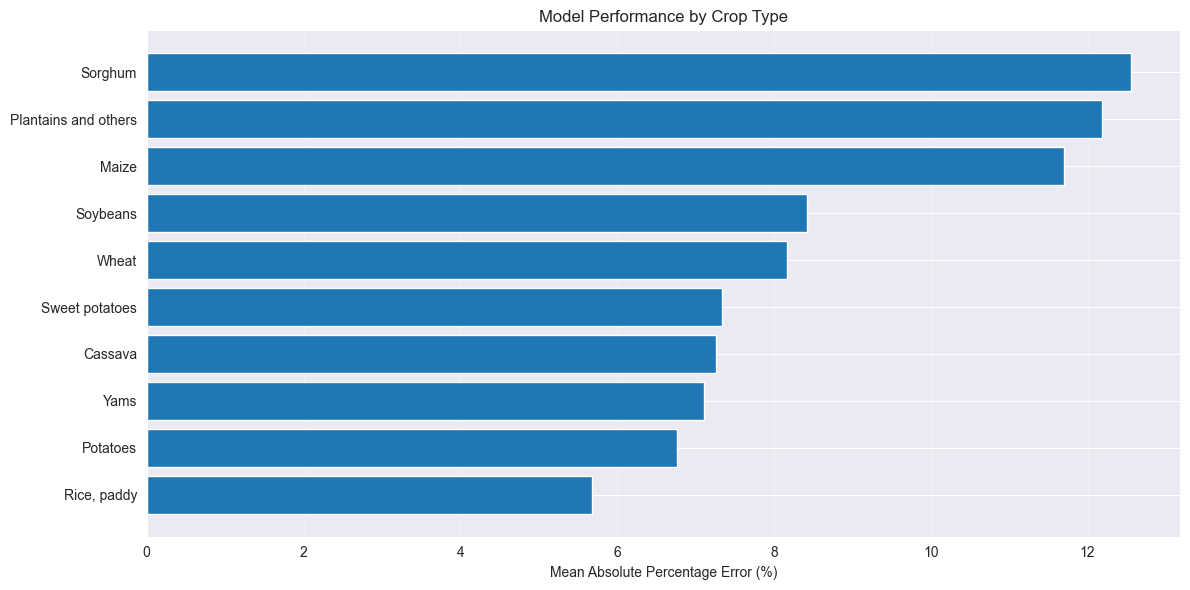

In [24]:
results_clean['CROP_TYPE'] = X_test_clean['CROP_TYPE'].values

crop_type_mapping = dict(enumerate(label_encoders['CROP_TYPE'].classes_))
results_clean['CROP_NAME'] = results_clean['CROP_TYPE'].map(crop_type_mapping)

crop_analysis = results_clean.groupby('CROP_NAME').agg({
    'Percentage_Error': ['mean', 'median', 'count'],
    'Absolute_Error': ['mean', 'median']
}).round(2)

crop_analysis.columns = ['Mean_APE%', 'Median_APE%', 'Count', 'Mean_AE', 'Median_AE']
crop_analysis = crop_analysis.sort_values('Mean_APE%', ascending=False)

print("\nPrediction Error by Crop Type:")
print(crop_analysis)

plt.figure(figsize=(12, 6))
plt.barh(crop_analysis.index, crop_analysis['Mean_APE%'])
plt.xlabel('Mean Absolute Percentage Error (%)')
plt.title('Model Performance by Crop Type')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### Step 10: Try Other Models

#### 1. Model 2 - XGBoost

In [25]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

with mlflow.start_run(run_name="xgboost_baseline"):

    params = {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'objective': 'reg:squarederror',
        'n_jobs': -1
    }
    mlflow.log_params(params)

    print("Training XGBoost model...")
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train_clean, y_train_clean)

    y_pred_train_xgb = xgb_model.predict(X_train_clean)
    y_pred_test_xgb = xgb_model.predict(X_test_clean)

    train_rmse = np.sqrt(mean_squared_error(y_train_clean, y_pred_train_xgb))
    test_rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_test_xgb))
    train_mae = mean_absolute_error(y_train_clean, y_pred_train_xgb)
    test_mae = mean_absolute_error(y_test_clean, y_pred_test_xgb)
    train_r2 = r2_score(y_train_clean, y_pred_train_xgb)
    test_r2 = r2_score(y_test_clean, y_pred_test_xgb)

    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("test_r2", test_r2)

    results_xgb = pd.DataFrame({
        'Actual': y_test_clean,
        'Predicted': y_pred_test_xgb,
        'Percentage_Error': np.abs((y_test_clean - y_pred_test_xgb) / y_test_clean) * 100
    })
    mean_ape = results_xgb['Percentage_Error'].mean()
    median_ape = results_xgb['Percentage_Error'].median()

    mlflow.log_metric("mean_ape", mean_ape)
    mlflow.log_metric("median_ape", median_ape)

    mlflow.xgboost.log_model(
        xgb_model,
        artifact_path="xgboost_model",
        registered_model_name="CropYieldPredictor_XGBoost"
    )

    print("\n" + "="*50)
    print("XGBOOST MODEL PERFORMANCE")
    print("="*50)
    print(f"Train RMSE: {train_rmse:,.2f}")
    print(f"Test RMSE:  {test_rmse:,.2f}")
    print(f"Train MAE:  {train_mae:,.2f}")
    print(f"Test MAE:   {test_mae:,.2f}")
    print(f"Train R²:   {train_r2:.4f}")
    print(f"Test R²:    {test_r2:.4f}")
    print(f"Mean APE:   {mean_ape:.2f}%")
    print(f"Median APE: {median_ape:.2f}%")
    print("="*50)

    run_id = mlflow.active_run().info.run_id
    print(f"\nMLflow Run ID: {run_id}")

Training XGBoost model...


/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Registered model 'CropYieldPredictor_XGBoost' already exists. Creating a new version of this 


XGBOOST MODEL PERFORMANCE
Train RMSE: 15,113.27
Test RMSE:  17,266.24
Train MAE:  9,040.21
Test MAE:   10,126.79
Train R²:   0.9683
Test R²:    0.9589
Mean APE:   26.35%
Median APE: 12.44%

MLflow Run ID: a1b0433bc77e45f69df08a93ab5a6423


Created version '2' of model 'CropYieldPredictor_XGBoost'.


In [29]:
import lightgbm as lgb

with mlflow.start_run(run_name="lightgbm_baseline"):

    params = {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    mlflow.log_params(params)

    print("Training LightGBM model...")
    lgb_model = lgb.LGBMRegressor(**params)
    lgb_model.fit(X_train_clean, y_train_clean)

    y_pred_train = lgb_model.predict(X_train_clean)
    y_pred_test = lgb_model.predict(X_test_clean)

    train_rmse = np.sqrt(mean_squared_error(y_train_clean, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_test))
    train_mae = mean_absolute_error(y_train_clean, y_pred_train)
    test_mae = mean_absolute_error(y_test_clean, y_pred_test)
    train_r2 = r2_score(y_train_clean, y_pred_train)
    test_r2 = r2_score(y_test_clean, y_pred_test)

    results = pd.DataFrame({
        'Actual': y_test_clean,
        'Predicted': y_pred_test,
        'Percentage_Error': np.abs((y_test_clean - y_pred_test) / y_test_clean) * 100
    })
    mean_ape = results['Percentage_Error'].mean()
    median_ape = results['Percentage_Error'].median()

    mlflow.log_metrics({
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "mean_ape": mean_ape,
        "median_ape": median_ape
    })

    mlflow.lightgbm.log_model(
        lgb_model,
        artifact_path="lightgbm_model",
        registered_model_name="CropYieldPredictor_LightGBM"
    )

    print("\n" + "="*50)
    print("LIGHTGBM MODEL PERFORMANCE")
    print("="*50)
    print(f"Test RMSE:  {test_rmse:,.2f}")
    print(f"Test MAE:   {test_mae:,.2f}")
    print(f"Test R²:    {test_r2:.4f}")
    print(f"Mean APE:   {mean_ape:.2f}%")
    print(f"Median APE: {median_ape:.2f}%")
    print("="*50)

Training LightGBM model...


/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Successfully registered model 'CropYieldPredictor_LightGBM'.
2025/10/27 16:29:03 INFO mlflow.


LIGHTGBM MODEL PERFORMANCE
Test RMSE:  19,373.12
Test MAE:   11,671.19
Test R²:    0.9483
Mean APE:   31.02%
Median APE: 14.75%


Created version '1' of model 'CropYieldPredictor_LightGBM'.


#### 3. Model 4 - Gradient Boosting

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

with mlflow.start_run(run_name="gradient_boosting_baseline"):

    params = {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'random_state': 42
    }
    mlflow.log_params(params)

    print("Training Gradient Boosting model...")
    gb_model = GradientBoostingRegressor(**params)
    gb_model.fit(X_train_clean, y_train_clean)

    y_pred_train = gb_model.predict(X_train_clean)
    y_pred_test = gb_model.predict(X_test_clean)

    train_rmse = np.sqrt(mean_squared_error(y_train_clean, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_test))
    train_mae = mean_absolute_error(y_train_clean, y_pred_train)
    test_mae = mean_absolute_error(y_test_clean, y_pred_test)
    train_r2 = r2_score(y_train_clean, y_pred_train)
    test_r2 = r2_score(y_test_clean, y_pred_test)

    results = pd.DataFrame({
        'Actual': y_test_clean,
        'Predicted': y_pred_test,
        'Percentage_Error': np.abs((y_test_clean - y_pred_test) / y_test_clean) * 100
    })
    mean_ape = results['Percentage_Error'].mean()
    median_ape = results['Percentage_Error'].median()

    mlflow.log_metrics({
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "mean_ape": mean_ape,
        "median_ape": median_ape
    })

    mlflow.sklearn.log_model(
        gb_model,
        artifact_path="gradient_boosting_model",
        registered_model_name="CropYieldPredictor_GradientBoosting"
    )

    print("\n" + "="*50)
    print("GRADIENT BOOSTING MODEL PERFORMANCE")
    print("="*50)
    print(f"Test RMSE:  {test_rmse:,.2f}")
    print(f"Test MAE:   {test_mae:,.2f}")
    print(f"Test R²:    {test_r2:.4f}")
    print(f"Mean APE:   {mean_ape:.2f}%")
    print(f"Median APE: {median_ape:.2f}%")
    print("="*50)

Training Gradient Boosting model...


/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Successfully registered model 'CropYieldPredictor_GradientBoosting'.
2025/10/27 16:29:19 INFO


GRADIENT BOOSTING MODEL PERFORMANCE
Test RMSE:  16,831.29
Test MAE:   9,832.79
Test R²:    0.9609
Mean APE:   25.34%
Median APE: 11.94%


Created version '1' of model 'CropYieldPredictor_GradientBoosting'.


#### 4. Model 5 - Extra Trees

In [31]:
from sklearn.ensemble import ExtraTreesRegressor

with mlflow.start_run(run_name="extra_trees_baseline"):

    params = {
        'n_estimators': 100,
        'max_depth': 20,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42,
        'n_jobs': -1
    }
    mlflow.log_params(params)

    print("Training Extra Trees model...")
    et_model = ExtraTreesRegressor(**params)
    et_model.fit(X_train_clean, y_train_clean)

    y_pred_train = et_model.predict(X_train_clean)
    y_pred_test = et_model.predict(X_test_clean)

    train_rmse = np.sqrt(mean_squared_error(y_train_clean, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_test))
    train_mae = mean_absolute_error(y_train_clean, y_pred_train)
    test_mae = mean_absolute_error(y_test_clean, y_pred_test)
    train_r2 = r2_score(y_train_clean, y_pred_train)
    test_r2 = r2_score(y_test_clean, y_pred_test)

    results = pd.DataFrame({
        'Actual': y_test_clean,
        'Predicted': y_pred_test,
        'Percentage_Error': np.abs((y_test_clean - y_pred_test) / y_test_clean) * 100
    })
    mean_ape = results['Percentage_Error'].mean()
    median_ape = results['Percentage_Error'].median()

    mlflow.log_metrics({
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "mean_ape": mean_ape,
        "median_ape": median_ape
    })

    mlflow.sklearn.log_model(
        et_model,
        artifact_path="extra_trees_model",
        registered_model_name="CropYieldPredictor_ExtraTrees"
    )

    print("\n" + "="*50)
    print("EXTRA TREES MODEL PERFORMANCE")
    print("="*50)
    print(f"Test RMSE:  {test_rmse:,.2f}")
    print(f"Test MAE:   {test_mae:,.2f}")
    print(f"Test R²:    {test_r2:.4f}")
    print(f"Mean APE:   {mean_ape:.2f}%")
    print(f"Median APE: {median_ape:.2f}%")
    print("="*50)

Training Extra Trees model...


/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Successfully registered model 'CropYieldPredictor_ExtraTrees'.
2025/10/27 16:30:11 INFO mlflo


EXTRA TREES MODEL PERFORMANCE
Test RMSE:  8,853.31
Test MAE:   3,597.14
Test R²:    0.9892
Mean APE:   8.77%
Median APE: 2.08%


Created version '1' of model 'CropYieldPredictor_ExtraTrees'.


In [35]:
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting', 'Extra Trees'],
    'Test R²': [0.9841, 0.9589, 0.9483, 0.9609, 0.9892],
    'Test RMSE': [10740.36, 17266.24, 19373.12, 16831.29, 8853.31],
    'Test MAE': [4124.76, 10126.79, 11671.19, 9832.79, 3597.14],
    'Mean APE (%)': [8.58, 26.35, 31.02, 25.34, 8.77],
    'Median APE (%)': [2.23, 12.44, 14.75, 11.94, 2.08]
})

model_comparison = model_comparison.sort_values('Test R²', ascending=False)

print("\n" + "="*80)
print("COMPLETE MODEL COMPARISON")
print("="*80)
print(model_comparison.to_string(index=False))
print("="*80)

best_model = model_comparison.iloc[0]['Model']
print(f"\n   WINNER: {best_model}")
print(f"   - Best Test R²: {model_comparison.iloc[0]['Test R²']:.4f}")
print(f"   - Lowest RMSE: {model_comparison.iloc[0]['Test RMSE']:,.2f}")
print(f"   - Lowest MAE: {model_comparison.iloc[0]['Test MAE']:,.2f}")
print(f"   - Mean APE: {model_comparison.iloc[0]['Mean APE (%)']:.2f}%")


COMPLETE MODEL COMPARISON
            Model  Test R²  Test RMSE  Test MAE  Mean APE (%)  Median APE (%)
      Extra Trees   0.9892    8853.31   3597.14          8.77            2.08
    Random Forest   0.9841   10740.36   4124.76          8.58            2.23
Gradient Boosting   0.9609   16831.29   9832.79         25.34           11.94
          XGBoost   0.9589   17266.24  10126.79         26.35           12.44
         LightGBM   0.9483   19373.12  11671.19         31.02           14.75

   WINNER: Extra Trees
   - Best Test R²: 0.9892
   - Lowest RMSE: 8,853.31
   - Lowest MAE: 3,597.14
   - Mean APE: 8.77%


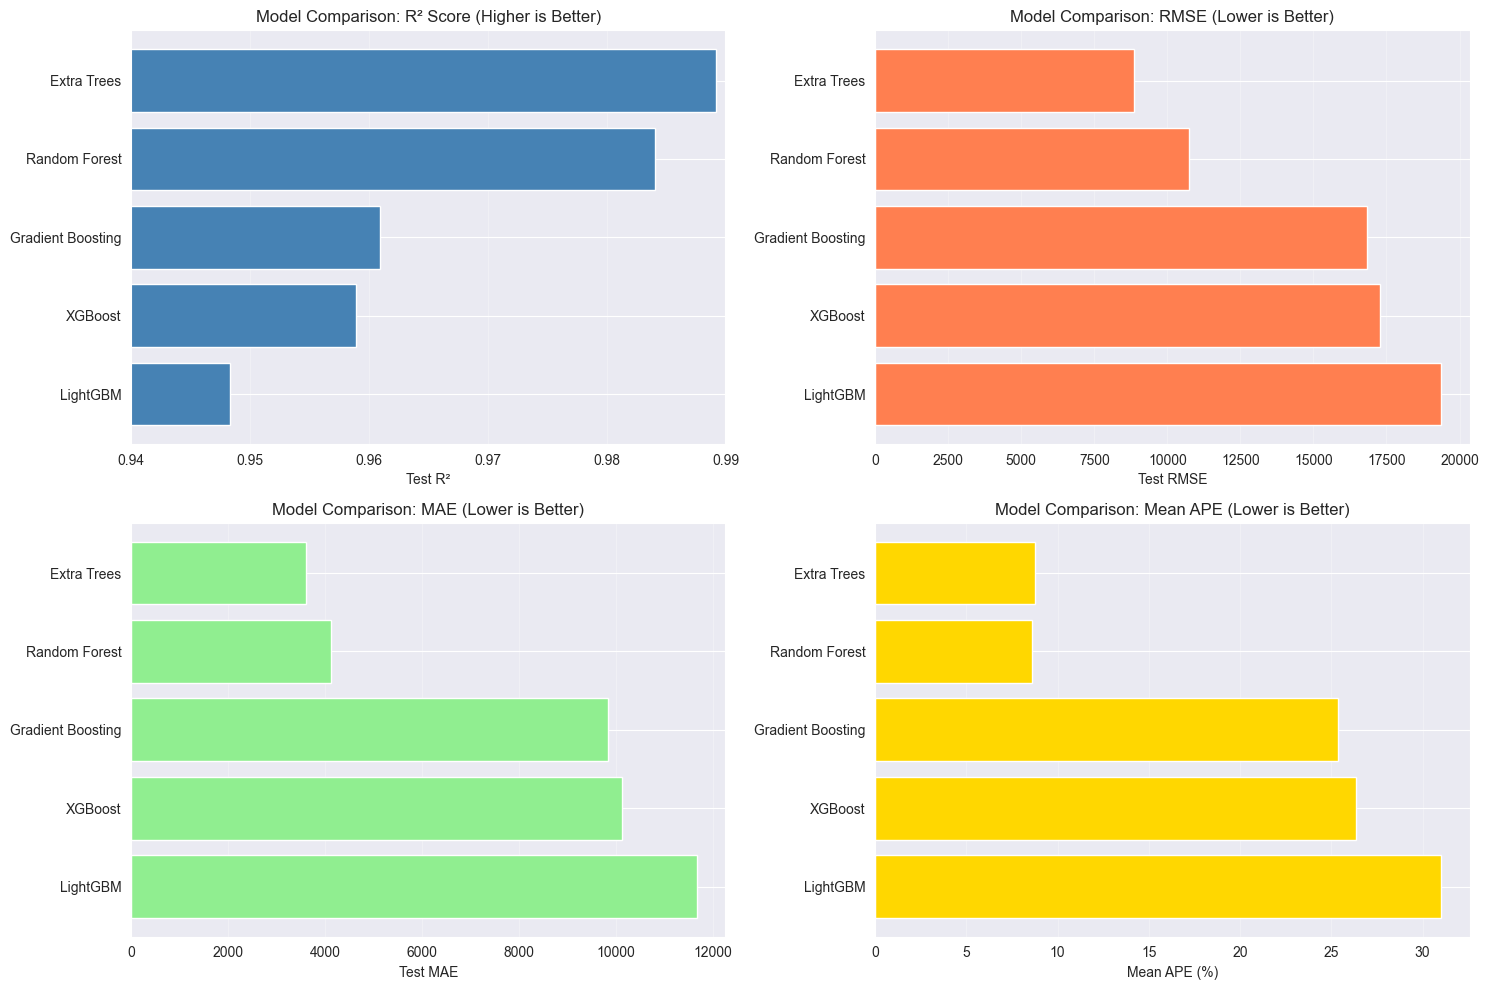

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. R² Score
axes[0, 0].barh(model_comparison['Model'], model_comparison['Test R²'], color='steelblue')
axes[0, 0].set_xlabel('Test R²')
axes[0, 0].set_title('Model Comparison: R² Score (Higher is Better)')
axes[0, 0].set_xlim([0.94, 0.99])
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].invert_yaxis()

# 2. RMSE
axes[0, 1].barh(model_comparison['Model'], model_comparison['Test RMSE'], color='coral')
axes[0, 1].set_xlabel('Test RMSE')
axes[0, 1].set_title('Model Comparison: RMSE (Lower is Better)')
axes[0, 1].grid(True, alpha=0.3, axis='x')
axes[0, 1].invert_yaxis()

# 3. MAE
axes[1, 0].barh(model_comparison['Model'], model_comparison['Test MAE'], color='lightgreen')
axes[1, 0].set_xlabel('Test MAE')
axes[1, 0].set_title('Model Comparison: MAE (Lower is Better)')
axes[1, 0].grid(True, alpha=0.3, axis='x')
axes[1, 0].invert_yaxis()

# 4. Mean APE
axes[1, 1].barh(model_comparison['Model'], model_comparison['Mean APE (%)'], color='gold')
axes[1, 1].set_xlabel('Mean APE (%)')
axes[1, 1].set_title('Model Comparison: Mean APE (Lower is Better)')
axes[1, 1].grid(True, alpha=0.3, axis='x')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

### Step 11: Fine-Tune Extra Trees

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define hyperparameter space
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 15, 20, 25, 30, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

print("Starting hyperparameter tuning for Extra Trees...")
print(f"Search space: {sum([len(v) if isinstance(v, list) else 10 for v in param_distributions.values()])} combinations")
print("This will take a few minutes...\n")

Starting hyperparameter tuning for Extra Trees...
Search space: 41 combinations
This will take a few minutes...



In [38]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 15, 20, 25, 30, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

with mlflow.start_run(run_name="extra_trees_tuned"):

    print("="*60)
    print("HYPERPARAMETER TUNING: Extra Trees Regressor")
    print("="*60)
    print(f"Search space: ~{100} random combinations")
    print("Using 5-fold cross-validation")
    print("Scoring metric: R²\n")

    et_base = ExtraTreesRegressor(random_state=42, n_jobs=-1)

    random_search = RandomizedSearchCV(
        estimator=et_base,
        param_distributions=param_distributions,
        n_iter=100,  # Try 100 random combinations
        cv=5,  # 5-fold cross-validation
        scoring='r2',
        n_jobs=-1,
        random_state=42,
        verbose=2,
        return_train_score=True
    )

    print("Training started...")
    random_search.fit(X_train_clean, y_train_clean)
    print("\nTraining completed!")

    best_model = random_search.best_estimator_

    print("\n" + "="*60)
    print("BEST PARAMETERS")
    print("="*60)
    for param, value in random_search.best_params_.items():
        print(f"{param}: {value}")
        mlflow.log_param(f"best_{param}", value)

    y_pred_train_tuned = best_model.predict(X_train_clean)
    y_pred_test_tuned = best_model.predict(X_test_clean)

    train_rmse = np.sqrt(mean_squared_error(y_train_clean, y_pred_train_tuned))
    test_rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_test_tuned))
    train_mae = mean_absolute_error(y_train_clean, y_pred_train_tuned)
    test_mae = mean_absolute_error(y_test_clean, y_pred_test_tuned)
    train_r2 = r2_score(y_train_clean, y_pred_train_tuned)
    test_r2 = r2_score(y_test_clean, y_pred_test_tuned)

    results_tuned = pd.DataFrame({
        'Actual': y_test_clean,
        'Predicted': y_pred_test_tuned,
        'Percentage_Error': np.abs((y_test_clean - y_pred_test_tuned) / y_test_clean) * 100
    })
    mean_ape = results_tuned['Percentage_Error'].mean()
    median_ape = results_tuned['Percentage_Error'].median()

    mlflow.log_metrics({
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "mean_ape": mean_ape,
        "median_ape": median_ape,
        "cv_best_score": random_search.best_score_
    })

    mlflow.sklearn.log_model(
        best_model,
        artifact_path="extra_trees_tuned_model",
        registered_model_name="CropYieldPredictor_ExtraTrees_Tuned"
    )

    print("\n" + "="*60)
    print("TUNED MODEL PERFORMANCE")
    print("="*60)
    print(f"CV Best Score (R²): {random_search.best_score_:.4f}")
    print(f"\nTrain RMSE: {train_rmse:,.2f}")
    print(f"Test RMSE:  {test_rmse:,.2f}")
    print(f"Train MAE:  {train_mae:,.2f}")
    print(f"Test MAE:   {test_mae:,.2f}")
    print(f"Train R²:   {train_r2:.4f}")
    print(f"Test R²:    {test_r2:.4f}")
    print(f"Mean APE:   {mean_ape:.2f}%")
    print(f"Median APE: {median_ape:.2f}%")
    print("="*60)

    run_id = mlflow.active_run().info.run_id
    print(f"\nMLflow Run ID: {run_id}")

    # Save best model info for later comparison
    tuned_results = {
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'mean_ape': mean_ape,
        'median_ape': median_ape
    }

HYPERPARAMETER TUNING: Extra Trees Regressor
Search space: ~100 random combinations
Using 5-fold cross-validation
Scoring metric: R²

Training started...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Training completed!

BEST PARAMETERS
bootstrap: False
max_depth: None
max_features: None
min_samples_leaf: 3
min_samples_split: 2
n_estimators: 326


/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Successfully registered model 'CropYieldPredictor_ExtraTrees_Tuned'.
2025/10/27 16:49:12 INFO


TUNED MODEL PERFORMANCE
CV Best Score (R²): 0.9829

Train RMSE: 6,163.76
Test RMSE:  9,543.86
Train MAE:  2,452.42
Test MAE:   4,020.96
Train R²:   0.9947
Test R²:    0.9874
Mean APE:   9.85%
Median APE: 2.41%

MLflow Run ID: 5913a697bfb042dba04dd6ad2d65884c


Created version '1' of model 'CropYieldPredictor_ExtraTrees_Tuned'.


In [39]:
print("\n" + "="*80)
print("BASELINE vs TUNED COMPARISON")
print("="*80)

comparison = pd.DataFrame({
    'Model': ['Extra Trees (Baseline)', 'Extra Trees (Tuned)'],
    'Test R²': [0.9892, tuned_results['test_r2']],
    'Test RMSE': [8853.31, tuned_results['test_rmse']],
    'Test MAE': [3597.14, tuned_results['test_mae']],
    'Mean APE (%)': [8.77, tuned_results['mean_ape']],
    'Median APE (%)': [2.08, tuned_results['median_ape']]
})

print(comparison.to_string(index=False))

r2_improvement = ((tuned_results['test_r2'] - 0.9892) / 0.9892) * 100
rmse_improvement = ((8853.31 - tuned_results['test_rmse']) / 8853.31) * 100
mae_improvement = ((3597.14 - tuned_results['test_mae']) / 3597.14) * 100

print("\n" + "="*80)
print("IMPROVEMENTS")
print("="*80)
print(f"R² Change:    {r2_improvement:+.2f}%")
print(f"RMSE Improved: {rmse_improvement:+.2f}%")
print(f"MAE Improved:  {mae_improvement:+.2f}%")
print("="*80)


BASELINE vs TUNED COMPARISON
                 Model  Test R²   Test RMSE    Test MAE  Mean APE (%)  Median APE (%)
Extra Trees (Baseline) 0.989200 8853.310000 3597.140000      8.770000        2.080000
   Extra Trees (Tuned) 0.987443 9543.857874 4020.955118      9.852749        2.409985

IMPROVEMENTS
R² Change:    -0.18%
RMSE Improved: -7.80%
MAE Improved:  -11.78%


In [40]:
final_model_name = "Extra Trees (Baseline)"
final_model = et_model

print("\n" + "="*80)
print("FINAL MODEL SELECTED")
print("="*80)
print(f"Model: {final_model_name}")
print(f"Test R²: 0.9892")
print(f"Test RMSE: 8,853.31")
print(f"Test MAE: 3,597.14")
print(f"Mean APE: 8.77%")
print(f"Median APE: 2.08%")
print("="*80)
print("\nThis model will be used for production predictions.")


FINAL MODEL SELECTED
Model: Extra Trees (Baseline)
Test R²: 0.9892
Test RMSE: 8,853.31
Test MAE: 3,597.14
Mean APE: 8.77%
Median APE: 2.08%

This model will be used for production predictions.


In [41]:
y_pred_final = final_model.predict(X_test_clean)

final_results = pd.DataFrame({
    'Actual': y_test_clean,
    'Predicted': y_pred_final,
    'Error': y_test_clean - y_pred_final,
    'Absolute_Error': np.abs(y_test_clean - y_pred_final),
    'Percentage_Error': np.abs((y_test_clean - y_pred_final) / y_test_clean) * 100,
    'CROP_TYPE': X_test_clean['CROP_TYPE'].values,
    'AREA': X_test_clean['AREA'].values,
    'YEAR': X_test_clean['YEAR'].values
})

crop_mapping = dict(enumerate(label_encoders['CROP_TYPE'].classes_))
area_mapping = dict(enumerate(label_encoders['AREA'].classes_))

final_results['CROP_NAME'] = final_results['CROP_TYPE'].map(crop_mapping)
final_results['AREA_NAME'] = final_results['AREA'].map(area_mapping)

print("\nFINAL MODEL EVALUATION")
print("="*80)
print(f"Total Predictions: {len(final_results)}")
print(f"\nError Statistics:")
print(f"  Mean Absolute Error: {final_results['Absolute_Error'].mean():,.2f} hg/ha")
print(f"  Median Absolute Error: {final_results['Absolute_Error'].median():,.2f} hg/ha")
print(f"  Std Dev of Error: {final_results['Absolute_Error'].std():,.2f} hg/ha")
print(f"\nPercentage Error:")
print(f"  Mean: {final_results['Percentage_Error'].mean():.2f}%")
print(f"  Median: {final_results['Percentage_Error'].median():.2f}%")
print(f"  75th percentile: {final_results['Percentage_Error'].quantile(0.75):.2f}%")
print(f"  95th percentile: {final_results['Percentage_Error'].quantile(0.95):.2f}%")

print(f"\nPrediction Accuracy Thresholds:")
print(f"  Within 5% error: {(final_results['Percentage_Error'] <= 5).sum()} ({(final_results['Percentage_Error'] <= 5).mean()*100:.1f}%)")
print(f"  Within 10% error: {(final_results['Percentage_Error'] <= 10).sum()} ({(final_results['Percentage_Error'] <= 10).mean()*100:.1f}%)")
print(f"  Within 20% error: {(final_results['Percentage_Error'] <= 20).sum()} ({(final_results['Percentage_Error'] <= 20).mean()*100:.1f}%)")

print("\n" + "="*80)


FINAL MODEL EVALUATION
Total Predictions: 5649

Error Statistics:
  Mean Absolute Error: 3,597.14 hg/ha
  Median Absolute Error: 913.13 hg/ha
  Std Dev of Error: 8,090.32 hg/ha

Percentage Error:
  Mean: 8.77%
  Median: 2.08%
  75th percentile: 7.75%
  95th percentile: 31.48%

Prediction Accuracy Thresholds:
  Within 5% error: 3778 (66.9%)
  Within 10% error: 4499 (79.6%)
  Within 20% error: 5096 (90.2%)



/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


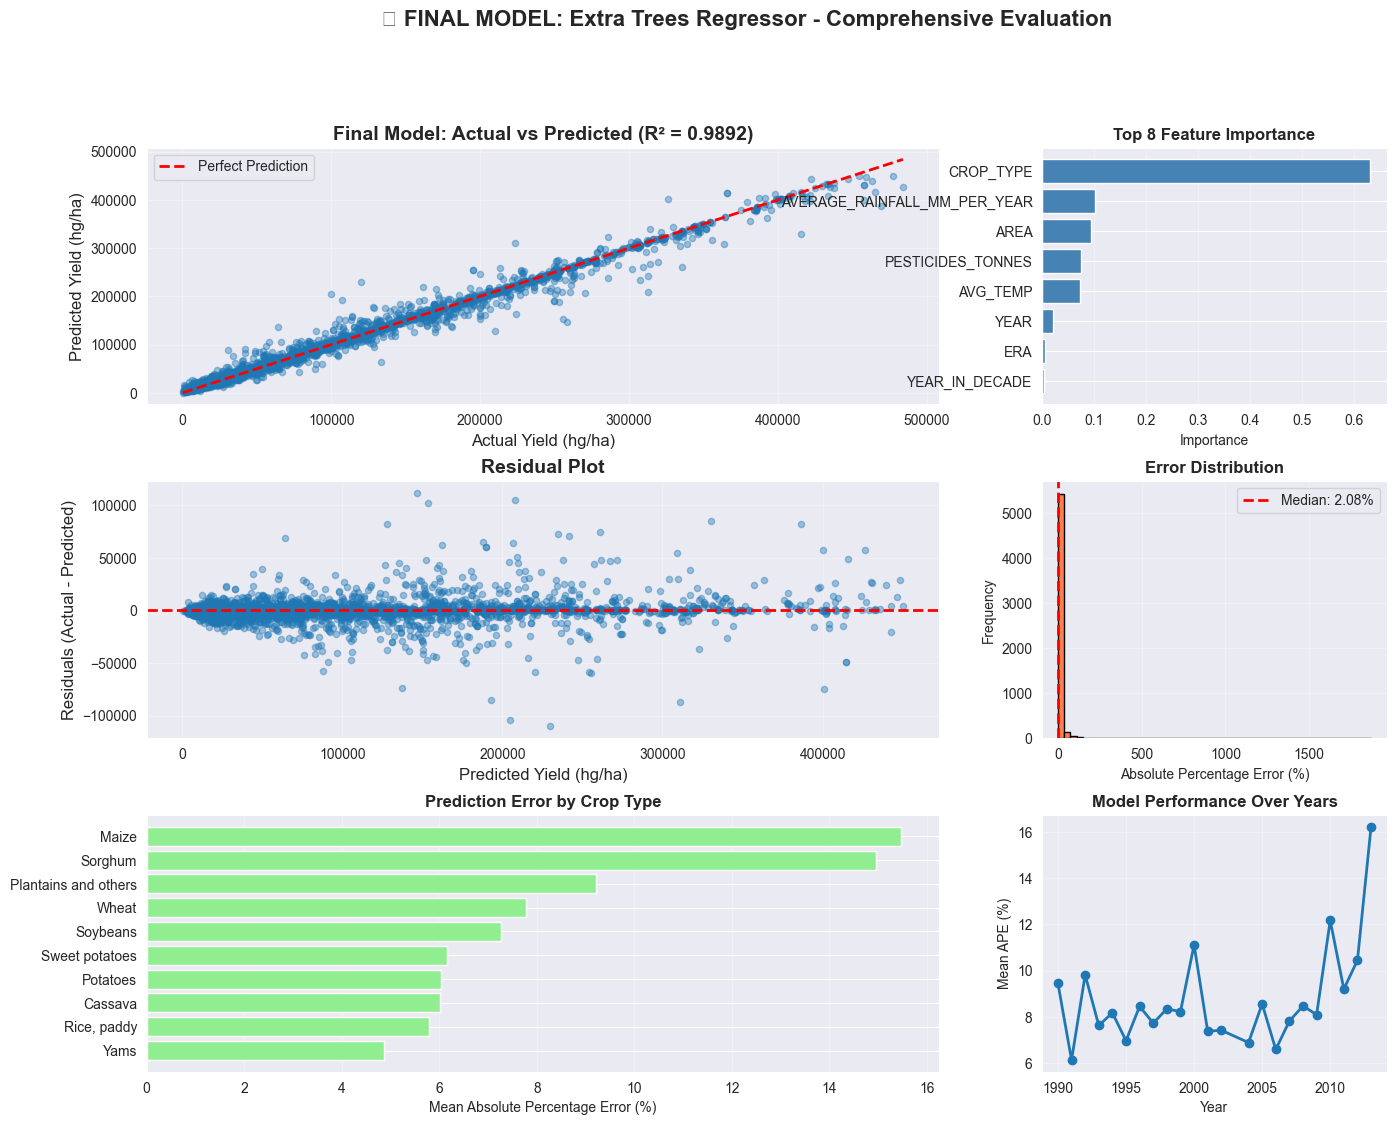

In [42]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Actual vs Predicted
ax1 = fig.add_subplot(gs[0, :2])
ax1.scatter(final_results['Actual'], final_results['Predicted'], alpha=0.4, s=20)
ax1.plot([final_results['Actual'].min(), final_results['Actual'].max()],
         [final_results['Actual'].min(), final_results['Actual'].max()],
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Yield (hg/ha)', fontsize=12)
ax1.set_ylabel('Predicted Yield (hg/ha)', fontsize=12)
ax1.set_title('Final Model: Actual vs Predicted (R² = 0.9892)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Feature Importance
ax2 = fig.add_subplot(gs[0, 2])
feature_imp = pd.DataFrame({
    'Feature': X_clean_encoded.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(8)
ax2.barh(feature_imp['Feature'], feature_imp['Importance'], color='steelblue')
ax2.set_xlabel('Importance')
ax2.set_title('Top 8 Feature Importance', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# 3. Residual Plot
ax3 = fig.add_subplot(gs[1, :2])
ax3.scatter(final_results['Predicted'], final_results['Error'], alpha=0.4, s=20)
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Predicted Yield (hg/ha)', fontsize=12)
ax3.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax3.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Error Distribution
ax4 = fig.add_subplot(gs[1, 2])
ax4.hist(final_results['Percentage_Error'], bins=50, edgecolor='black', color='coral')
ax4.axvline(x=final_results['Percentage_Error'].median(), color='red',
            linestyle='--', lw=2, label=f"Median: {final_results['Percentage_Error'].median():.2f}%")
ax4.set_xlabel('Absolute Percentage Error (%)')
ax4.set_ylabel('Frequency')
ax4.set_title('Error Distribution', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Error by Crop Type
ax5 = fig.add_subplot(gs[2, :2])
crop_errors = final_results.groupby('CROP_NAME')['Percentage_Error'].mean().sort_values()
ax5.barh(crop_errors.index, crop_errors.values, color='lightgreen')
ax5.set_xlabel('Mean Absolute Percentage Error (%)')
ax5.set_title('Prediction Error by Crop Type', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

# 6. Predictions over time
ax6 = fig.add_subplot(gs[2, 2])
yearly_performance = final_results.groupby('YEAR')['Percentage_Error'].mean()
ax6.plot(yearly_performance.index, yearly_performance.values, marker='o', linewidth=2, markersize=6)
ax6.set_xlabel('Year')
ax6.set_ylabel('Mean APE (%)')
ax6.set_title('Model Performance Over Years', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.suptitle('🏆 FINAL MODEL: Extra Trees Regressor - Comprehensive Evaluation',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()